In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torchvision

In [8]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [9]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])


In [10]:
X = torch.rand(size=(1, 3, 320, 480))

net(X).shape

torch.Size([1, 512, 10, 15])

In [11]:
num_class = 21
net.add_module('final_conv', nn.Conv2d(512, num_class, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_class, num_class, kernel_size=64, stride=32, padding=16))

In [12]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size+1)//2
    if kernel_size %2==1:
        center = factor - 1
    else :
        center  = factor -0.5
    og = [torch.arange(kernel_size).reshape(-1, 1), 
          torch.arange(kernel_size).reshape(1, -1)]
    filt = (1 - torch.abs(og[0] - center) / factor) * \
            (1- torch.abs(og[1] - center)/ factor)
    
    weight = torch.zeros(size=(in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), : , :] = filt
    return weight



In [13]:
conv_trans = nn.ConvTranspose2d(3, 3,kernel_size=4, padding=1, stride=2,bias = False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [14]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()


input image shape size torch.Size([561, 728, 3])


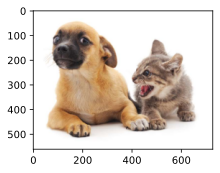

In [15]:
d2l.set_figsize()
print('input image shape size', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));



out image shape size  torch.Size([1122, 1456, 3])


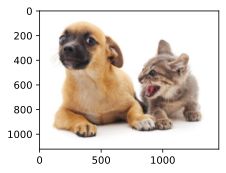

In [16]:
print('out image shape size ', out_img.shape)
d2l.plt.imshow(out_img);

In [17]:
W = bilinear_kernel(num_class, num_class, 64)
net. transpose_conv.weight.data.copy_(W);   

In [18]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size=batch_size, crop_size=crop_size)


read 1114 examples
read 1078 examples


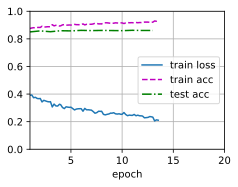

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epoch, lr , wd, devices = 20, 0.001, 1e-3, d2l.try_all_gpus()

trainer = torch.optim.SGD(net.parameters(), lr = lr, weight_decay = wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epoch, devices)

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    color_map = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return color_map[X, :]
    

In [ ]:
import torchvision.transforms.functional


voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n ,img = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    img += [X.permute(1, 2, 0), pred.cpu(), 
            torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1, 2, 0)]


d2l.show_images(img[::3] + img[1::3] + img[2::3], 3, n, scale=2);
    